In [3]:
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import numpy as np
import open3d as o3d
import seaborn as sns

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# Standard Variablen

In [1]:
depth_image_url = r"C:\Users\Diren\Nextcloud\HTW\4.Semester-Masterarbeit\Masterarbeit\Code\Tiefenkarten\20241207_171339_DepthMap.tiff"
rgb_image_url = r"C:\Users\Diren\Nextcloud\HTW\4.Semester-Masterarbeit\Masterarbeit\Code\TestBilder\20241207_171339.jpg"

# Visualizing depth map

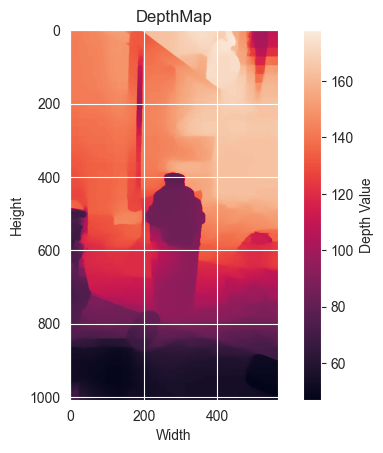

In [4]:


depth_im = Image.open(depth_image_url)  # Quelle: https://stackoverflow.com/a/67346474
dm_width, dm_height = depth_im.size  # width and height of depthmap image

depth_array = np.array(depth_im)  # getting the depthmap as a numpy array

# plotting the depthmap
plt.imshow(depth_array)
plt.colorbar(label="Depth Value")
plt.title("DepthMap")
plt.ylabel("Height")
plt.xlabel("Width")
plt.show()
